In [1]:
import sys
sys.path.append('../')

import copy
import glob

from typing import Tuple, Union, List
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm as tqdm

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample as ho_sample

import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader, Dataset, Sampler, SubsetRandomSampler

from torchmetrics import R2Score

import torch_geometric as pyg
from torch_geometric.nn import GCNConv
from torch_geometric.utils.convert import from_networkx
from torch_geometric.data import InMemoryDataset
import torch_scatter
import pytorch_forecasting as pyf

from src.utils import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(17)
plt.figure(figsize=(20, 12));

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu');
# device = torch.device('cpu')

/home/eldervald/miniconda3/envs/traffic/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


<Figure size 1440x864 with 0 Axes>

In [2]:
G = nx.readwrite.read_gpickle('data/network32.gpickle')
nx.set_node_attributes(G, {n: {'id': n} for n in G.nodes()})

In [3]:
# Pytorch geometric Data object.
pyg_data = from_networkx(G, group_node_attrs=['embedding'])
pyg_data.to(device);
pyg_data

/home/eldervald/miniconda3/envs/traffic/lib/python3.7/site-packages/torch_geometric/utils/convert.py:178: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/torch/csrc/utils/tensor_new.cpp:210.)
  data[key] = torch.tensor(value)


Data(edge_index=[2, 2306], id=[1128], x=[1128, 32])

In [4]:
# if more than 5% of time series for a station is missed -> drop the station
# also i'm dropping last 7% of the observations due it feels like an anomaly behavior

# preprocessing
intensity = pd.read_csv('data/intensity.csv')
intensity = intensity.loc[:int(len(intensity) * 0.93)]
intensity = intensity.loc[:, intensity.isna().sum() / len(intensity) < 0.05]
intensity = intensity.fillna(method='ffill')
intensity = intensity.fillna(0)
intensity.head(6)

,datetime,D00-001,D00-002,D00-003,D00-004,D00-005,D00-006,D00-007,D00-008,D00-009,...,I52-010,I52-011,I52-012,I52-013,I52-014,I52-015,I52-016,I52-017,I55-001,I55-002
0,2022-01-17 19:00:00,100,108,123,134,138,122,132.0,130,121,...,31.0,26.0,25.0,37.0,37.0,40.0,38.0,35.0,14.0,11.0
1,2022-01-17 19:15:00,118,108,123,117,115,116,128.0,126,148,...,24.0,31.0,32.0,32.0,34.0,34.0,31.0,30.0,5.0,7.0
2,2022-01-17 19:30:00,81,85,131,93,90,88,86.0,82,100,...,35.0,37.0,39.0,44.0,46.0,40.0,43.0,40.0,11.0,6.0
3,2022-01-17 19:45:00,68,70,103,87,96,103,121.0,123,124,...,29.0,25.0,31.0,28.0,28.0,37.0,33.0,43.0,8.0,7.0
4,2022-01-17 20:00:00,80,79,119,147,140,130,125.0,119,121,...,25.0,26.0,25.0,25.0,27.0,25.0,19.0,24.0,6.0,8.0
5,2022-01-17 20:15:00,87,84,79,100,102,96,105.0,116,135,...,19.0,27.0,24.0,24.0,27.0,35.0,36.0,33.0,9.0,10.0


In [5]:
nodes = intensity.columns[1:].to_list()
nodes[:5]

['D00-001', 'D00-002', 'D00-003', 'D00-004', 'D00-005']

In [6]:
avg_speed = pd.read_csv('data/avg_speed.csv')
avg_speed = avg_speed.loc[:int(len(avg_speed) * 0.93)]
avg_speed = avg_speed.fillna(method='ffill')
avg_speed = avg_speed[['datetime'] + nodes]
avg_speed = avg_speed.fillna(avg_speed.mean())
avg_speed.tail(3)

/home/eldervald/miniconda3/envs/traffic/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


,datetime,D00-001,D00-002,D00-003,D00-004,D00-005,D00-006,D00-007,D00-008,D00-009,...,I52-010,I52-011,I52-012,I52-013,I52-014,I52-015,I52-016,I52-017,I55-001,I55-002
2828,2022-02-16 06:00:00,73.349998,56.610000,48.382500,85.775002,85.590000,81.684999,83.274998,71.850000,57.825001,...,84.309999,84.6500,75.994999,71.132500,74.2925,77.867500,67.544999,65.120001,74.624998,84.844999
2829,2022-02-16 06:15:00,69.877500,52.262500,52.082500,85.777500,86.189999,80.479998,82.875000,56.850001,58.615000,...,83.323334,82.2300,79.867500,72.219999,76.9900,78.087500,69.157499,64.647499,75.977499,84.955000
2830,2022-02-16 06:30:00,74.815001,59.035002,52.932499,85.897499,85.682499,81.477499,84.255001,56.000001,63.514998,...,76.022499,77.1175,78.715002,72.397499,76.4175,76.352499,70.812498,64.337500,75.322498,82.709999


In [7]:
len(nodes)

731

In [8]:
# removing dropped nodes from the initial graph
pyg_data = pyg_data.subgraph(torch.tensor([pyg_data.id.index(x) for x in nodes]))
pyg_data.id = nodes
pyg_data

Data(edge_index=[2, 1418], id=[731], x=[731, 32])

In [9]:
class StandardScaler(nn.Module):
    def fit(self, x):
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
        
    def transform(self, x):
        x -= self.mean
        x /= (self.std + 1e-7)
        return x

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

    def inverse_transform(self, x):
        x *= (self.std + 1e-7)
        x += self.mean
        return x

    def to(self, device):
        super().to(device)
        self.mean = self.mean.to(device)
        self.std = self.std.to(device)
        return self


In [10]:
class GraphSnapshotsDataset(Dataset):
    def __init__(self, target_snapshots: pd.DataFrame,
     pyg_data: pyg.data.Data, nodes_cols, features_snapshots: List[pd.DataFrame] = None, dt_column='datetime',
      seq_len=14, normalize=True):
        targets = target_snapshots[nodes_cols].values
        X = [targets]

        # concatenating features with target
        if features_snapshots is not None:
            X_feat = [feat_df[nodes_cols].values for feat_df in features_snapshots]
            X.extend(X_feat)
        # print([x.shape for x in X])
        self.X = torch.tensor(np.stack(X, axis=-1), dtype=torch.float32)

        self.y = torch.tensor(targets, dtype=torch.float32).unsqueeze(-1)

        self.pyg_data = pyg_data
        self.dts = pd.to_datetime(target_snapshots[dt_column], format='%Y-%m-%d %H:%M:%S')

        self.window = seq_len
        self.horizon = 1
        self.period = 24 * 4

        self.make_datetime_features()
        
        if self.pyg_data.x is None:
            raise AttributeError("embeddings not found")

        if normalize:
            self.feature_scaler = StandardScaler()
            self.target_scaler = StandardScaler()
            self.X = self.feature_scaler.fit_transform(self.X)
            self.y = self.target_scaler.fit_transform(self.y)

        self.shape = self.__getshape__()
        self.size = self.__getsize__()

    def make_datetime_features(self):
        """The idea here is to generate harmonic features of the time and date
        (projecting the time onto a circle and using two coordinates).
        
        The period here follows from the fact we are using 15 min interval between 2 consequential snapshots.
        The total number of obtained features is 5.
        """
        weekday = self.dts.dt.weekday.values
        is_weekend = (self.dts.dt.weekday > 4).values[:, None]
        dt = weekday * 2 * np.pi / 7.0
        dt_harmonic = np.stack([np.cos(dt), np.sin(dt)], axis=-1)
        tm = (self.dts.dt.hour.values * 4 + self.dts.dt.minute.values // 15)
        tm = tm * 2 * np.pi / self.period 
        tm_harmonic = np.stack([np.cos(tm), np.sin(tm)], axis=-1)
        
        self.dt_feats = torch.tensor(np.hstack([dt_harmonic, tm_harmonic, is_weekend]), dtype=torch.float32)

    def __getitem__(self, index):
        """Returns temporal nodes features, targets, edge_index,
         temporal snapshot features (only datetime yet) and node embeddings

        N - number of nodes
        F - number of observed features
        T - number of datetime features
        E - edges count
        W - sequence length
        D - node embedding dim

        Args:
            index (int): index

        Returns:
            Tuple(X[W, N, F], y[N, 1], edge_index[2, E]), DTX[W + 1, T], EMB[N, D])
        """
        X = self.X[index: index + self.window]

        y = self.y[index + self.window: index + self.window + self.horizon].squeeze(0)
        dt_feats = self.dt_feats[index: index + self.window + 1]

        return X, y, self.pyg_data.edge_index, dt_feats, self.pyg_data.x

    def snapshots_num(self):
        return len(self.X)

    def __len__(self):
        return len(self.X) - self.window - self.horizon + 1
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape)
    
    def __getsize__(self):
        return (self.__len__())

In [11]:
dataset = GraphSnapshotsDataset(intensity, pyg_data, nodes, 
    features_snapshots=[avg_speed], seq_len=96, normalize=False)
# dataset = SnapshotTimeSeriesDataset(intensity, pyg_data, nodes, seq_len=96, normalize=False)
shapes = [x.shape for x in dataset[0]]
assert shapes[0][0] == 96 and shapes[0][1] == len(nodes)
assert shapes[3][0] == 97
assert shapes[1][0] == len(nodes) and shapes[1][1] == 1
shapes

[torch.Size([96, 731, 2]),
 torch.Size([731, 1]),
 torch.Size([2, 1418]),
 torch.Size([97, 5]),
 torch.Size([731, 32])]

In [12]:
from typing import Iterator, Iterable, Optional, Sequence, List, TypeVar, Generic, Sized, Union

class SubsetSampler(Sampler[int]):
    r"""Samples elements from a given list of indices, without replacement.

    Args:
        indices (sequence): a sequence of indices
    """
    indices: Sequence[int]

    def __init__(self, indices: Sequence[int]) -> None:
        self.indices = indices

    def __iter__(self) -> Iterator[int]:
        for x in self.indices:
            yield x

    def __len__(self) -> int:
        return len(self.indices)

def make_dataloaders(ds, batch_size=32, **kwargs):
    """generates dataloaders with respect to time series split
    Split: 60-20-20
    """
    total_obs = ds.snapshots_num()
    indices = list(range(total_obs))
    train_indices = indices[:int(total_obs * 0.6) - ds.window - ds.horizon + 1]
    val_indices = indices[int(total_obs * 0.6): int(total_obs * 0.8) - ds.window - ds.horizon + 1]
    test_indices = indices[int(total_obs * 0.8): len(ds)]
    # train_indices = indices[:int(len(ds) * 0.7)]
    # val_indices = indices[int(len(ds) * 0.7): int(len(ds) * 0.85)]
    # test_indices = indices[int(len(ds) * 0.8): len(ds)]

    train_loader = DataLoader(ds, sampler=SubsetRandomSampler(train_indices), batch_size=batch_size)
    val_loader = DataLoader(ds, sampler=SubsetSampler(val_indices), batch_size=batch_size)
    test_loader = DataLoader(ds, sampler=SubsetSampler(test_indices), batch_size=batch_size)

    return train_loader, val_loader, test_loader

In [13]:
# ds = SnapshotTimeSeriesDataset(intensity, pyg_data, nodes, features_snapshots=[avg_speed], seq_len=4)
ds = GraphSnapshotsDataset(intensity, pyg_data, nodes, seq_len=4, normalize=True)
train_loader, val_loader, test_loader = make_dataloaders(ds, batch_size=16)

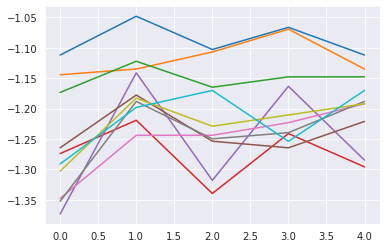

In [14]:
# testing loader
batch = next(iter(train_loader))
plt.plot(np.vstack([batch[0][0, :, :10, 0].detach().numpy(), batch[1][0, :10, 0].detach().numpy()]))
plt.show()

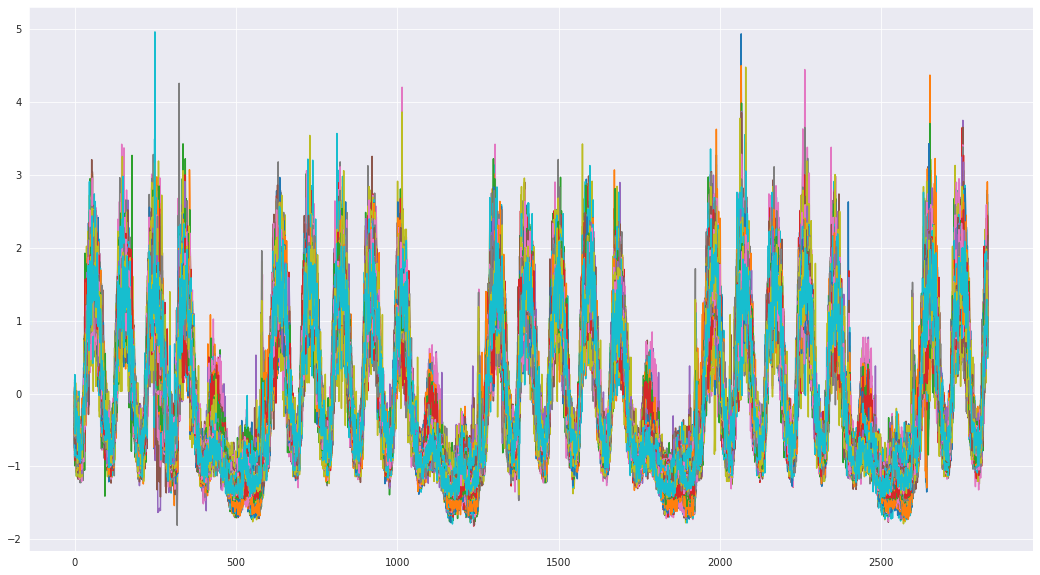

In [15]:
# ploting series for 200 nodes
plt.figure(figsize=(18, 10))
plt.plot(ds.y[:, :200].squeeze().detach().cpu())
plt.show();

In [56]:
from statistics import mean


def show_train_plot(train_losses: Sequence[int], val_losses: Sequence[int], 
  val_scores: Sequence[int], train_scores: Sequence[int]=None):
    _, axes = plt.subplots(1, 2, figsize=(20, 6))
            
    sns.lineplot(ax=axes[0], x=range(len(train_losses)), y=train_losses, label='Train', color='blue')
    sns.lineplot(ax=axes[0], x=range(len(val_losses)), y=val_losses, label='Val', color='red')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    sns.lineplot(ax=axes[1], x=range(len(val_scores)), y=val_scores, label='Val', color='red')
    if train_scores is not None:
        sns.lineplot(ax=axes[1], x=range(len(train_scores)), y=train_scores, label='Train', color='blue')
    
    # axes[1].set_ylim(0.5, 1)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Score')
    axes[1].legend()

    plt.show()


def test(model, loader, loss_fn, score_fn, device) -> Tuple[float, float]:
    """ returns average loss and score
    """
    model.eval()

    losses = []

    outs, ys = [], []
    with torch.no_grad():
        for X, y, edge_index, X_dt, emb in loader:
            X_gpu, X_dt_gpu, y_gpu, emb_gpu = X.to(device), X_dt.to(device), y.to(device), emb.to(device)
            out = model(X_gpu, edge_index=edge_index, X_dt=X_dt_gpu, emb=emb_gpu)

            outs.append(out)
            ys.append(y_gpu)
            loss = loss_fn(out, y_gpu)
            losses.append(loss.item())
    
    ys = torch.vstack(ys)
    outs = torch.vstack(outs)
    
    # the final score is calculated as mean of the day scores
    day_scores = [score_fn(outs[day: day+1], ys[day: day+1]).item() for day in range(len(ys))]
    return mean(losses), mean(day_scores)


def train(model, train_loader, val_loader,
    loss_fn, score_fn, optimizer, device, scheduler=None, num_epochs=10, plot=True, plot_update_freq=5):
    """ returns best model on validation
    """

    train_losses = []
    val_losses = []
    val_scores = []

    best_val_score = -torch.inf
    best_model = None

    for epoch in range(num_epochs + 1):
        model.train()
        losses = []
        for X, y, edge_index, X_dt, emb in train_loader:
            optimizer.zero_grad()
            X_gpu, X_dt_gpu, y_gpu, emb_gpu = X.to(device), X_dt.to(device), y.to(device), emb.to(device)
            out = model(X_gpu, edge_index=edge_index, X_dt=X_dt_gpu, emb=emb_gpu)
            loss = loss_fn(out, y_gpu)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            
        if scheduler is not None:
            scheduler.step()
        
        train_losses.append(mean(losses))
        val_loss, val_score = test(model, val_loader, loss_fn, score_fn, device)
        val_losses.append(val_loss)
        val_scores.append(val_score)

        if val_score > best_val_score:
            best_val_score = val_score
            best_model = copy.deepcopy(model)

        if plot and epoch > 0 and epoch % plot_update_freq == 0:
            clear_output(True)
            show_train_plot(train_losses, val_losses, val_scores)
    
        # print(f'Epoch {epoch}, Loss: {train_losses[-1]:.4f}, Val loss: {val_loss:.4f}, Val R2: {val_scores[-1]:.4f}')
    return best_model

In [57]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [58]:
# Train proccess runs with scaled targets (RNNs are very data demanding), 
# thus before counting score it needs unscaling targets
# to get score on the original data.
class UnscaledScore():
    def __init__(self, score_fn, scaler) -> None:
        self.score_fn = score_fn
        self.scaler = scaler
    def __call__(self, y_pred, y_true):
        y_pred = self.scaler.inverse_transform(y_pred)
        y_true = self.scaler.inverse_transform(y_true)
        res = self.score_fn(y_pred.reshape(-1), y_true.reshape(-1))
        # res *= res > 0
        return res

In [59]:
# loss_fn = nn.MSELoss().to(device)
loss_fn = nn.L1Loss().to(device)
scaler = copy.deepcopy(ds.target_scaler).to(device)
score_fn = UnscaledScore(R2Score().to(device), scaler)
# score_fn = R2Score().to(device)
# score_fn = RMSELoss().to(device)
# score_fn = UnscaledScore(RMSELoss().to(device), scaler)


def run(model, results, lr=1e-3, *args, **kwargs):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-7)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.8)
        
    model = train(model, train_loader, val_loader,
        loss_fn, score_fn, optimizer, device, *args, **kwargs)

    test_loss, test_score = test(model, test_loader, loss_fn, score_fn, device)

    # for name, param in model.named_parameters():
        # print(name, param)

    if test_score is not torch.nan:
        results[f'{model.__class__.__name__}'] = test_score
    print(f'Type: {model.__class__.__name__}, Test loss: {test_loss:.2f}, Test score: {test_score:.4f}')

    return model

In [60]:
import random

def evaluate_plot(model, loader, scaler, nodes_ids=nodes, nodes_num=5):
    outs, ys = [], []
    fig, axes = plt.subplots(nodes_num, figsize=(20, nodes_num * 6))
    
    with torch.no_grad():
        for X, y, edge_index, X_dt, emb in loader:
            X_gpu, X_dt_gpu, y_gpu, emb_gpu = X.to(device), X_dt.to(device), y.to(device), emb.to(device)
            out = model(X_gpu, edge_index=edge_index, X_dt=X_dt_gpu, emb=emb_gpu)

            outs.append(out)
            ys.append(y_gpu)
        
        ys = scaler.inverse_transform(torch.vstack(ys)).detach().cpu().numpy()
        outs = scaler.inverse_transform(torch.vstack(outs)).detach().cpu().numpy()

        for idx, node in enumerate(random.choices(range(len(nodes_ids)), k=nodes_num)):
            axes[idx].set_title(nodes_ids[node])
            # axes[idx].plot(ds.y[test_loader.sampler.indices, node], label='actual', c='r')
            axes[idx].plot(ys[:, node, 0], label='actual', c='r')
            axes[idx].plot(outs[:, node, 0], label='pred', c='b')
            axes[idx].legend()
        plt.show()

In [61]:
results = {}

**Linear Model**

Running LinR on every node, input for the regression - seq_len * in_features 

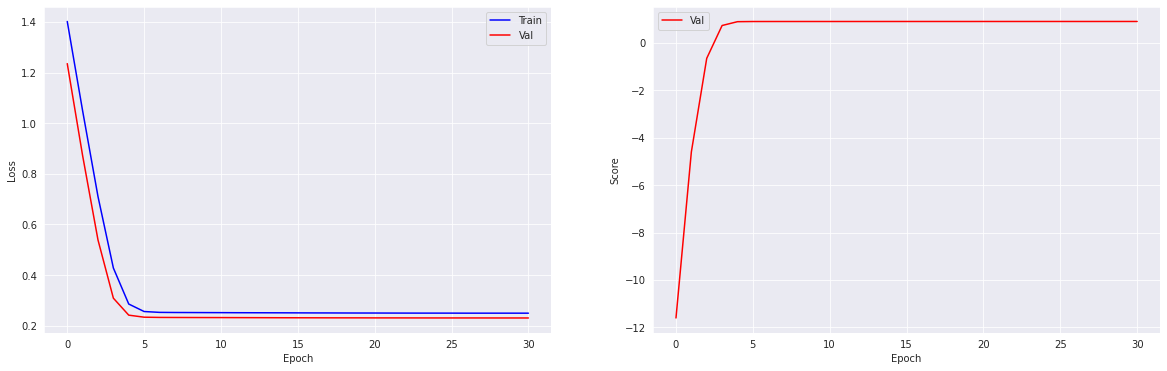

Type: LinearModel, Test loss: 0.23, Test score: 0.9003


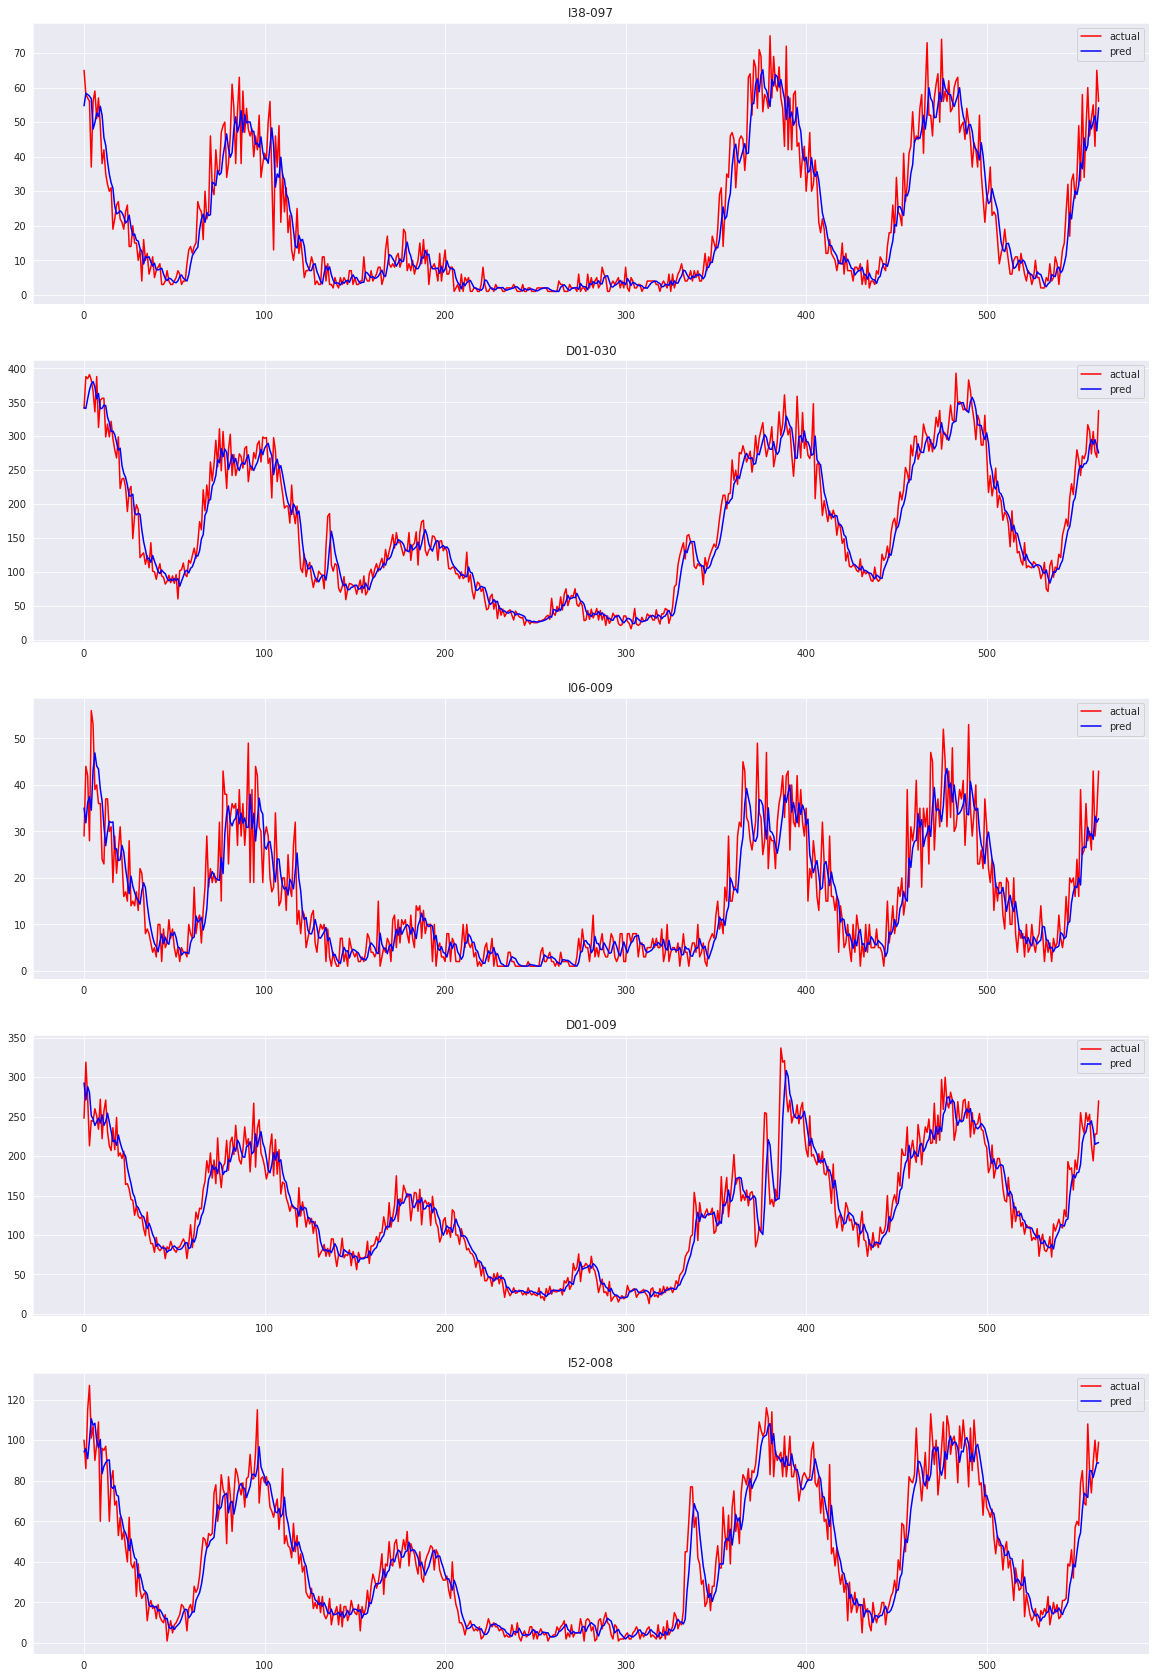

In [62]:
class LinearModel(nn.Module):
    def __init__(self, seq_len, in_channels, out_channels=1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.window = seq_len
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin = nn.Linear(self.window * self.in_channels, self.out_channels)
    
    def forward(self, X, *args, **kwargs):
        """X shape: [batch_num, seq_len, nodes_num, in_feature]"""
        X = X.transpose(1, 2)
        batch_size = X.shape[0]
        nodes_num = X.shape[1]
        X = X.reshape(batch_size, nodes_num, -1)
        
        out = self.lin(X)
        return out

model = LinearModel(seq_len=4, in_channels=1).to(device)
model = run(model, results, num_epochs=30, plot=True, plot_update_freq=5)
evaluate_plot(model, test_loader, scaler)

**VNN + Time Features**

Running MLP on every node, input for the regression - seq_len * (in_features + dt_features)<br>
DT features are passed through MLP, before concatenating

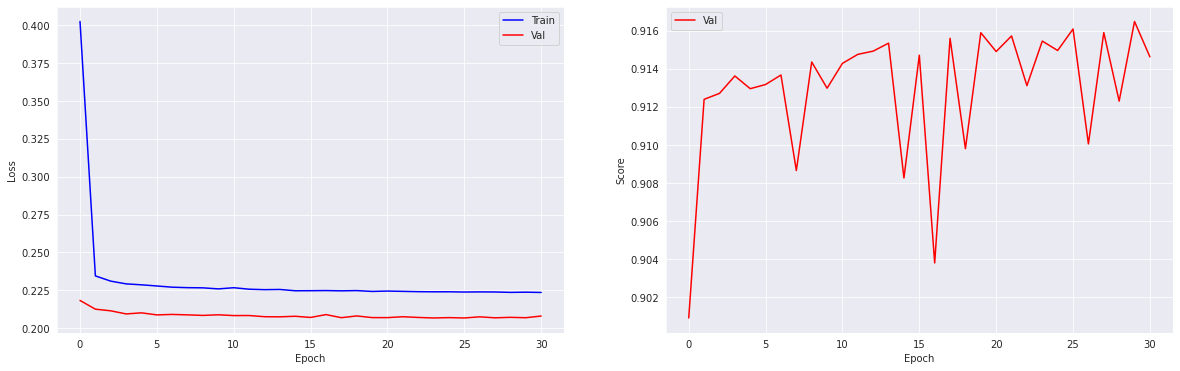

Type: VNNWithDtModel, Test loss: 0.21, Test score: 0.9127


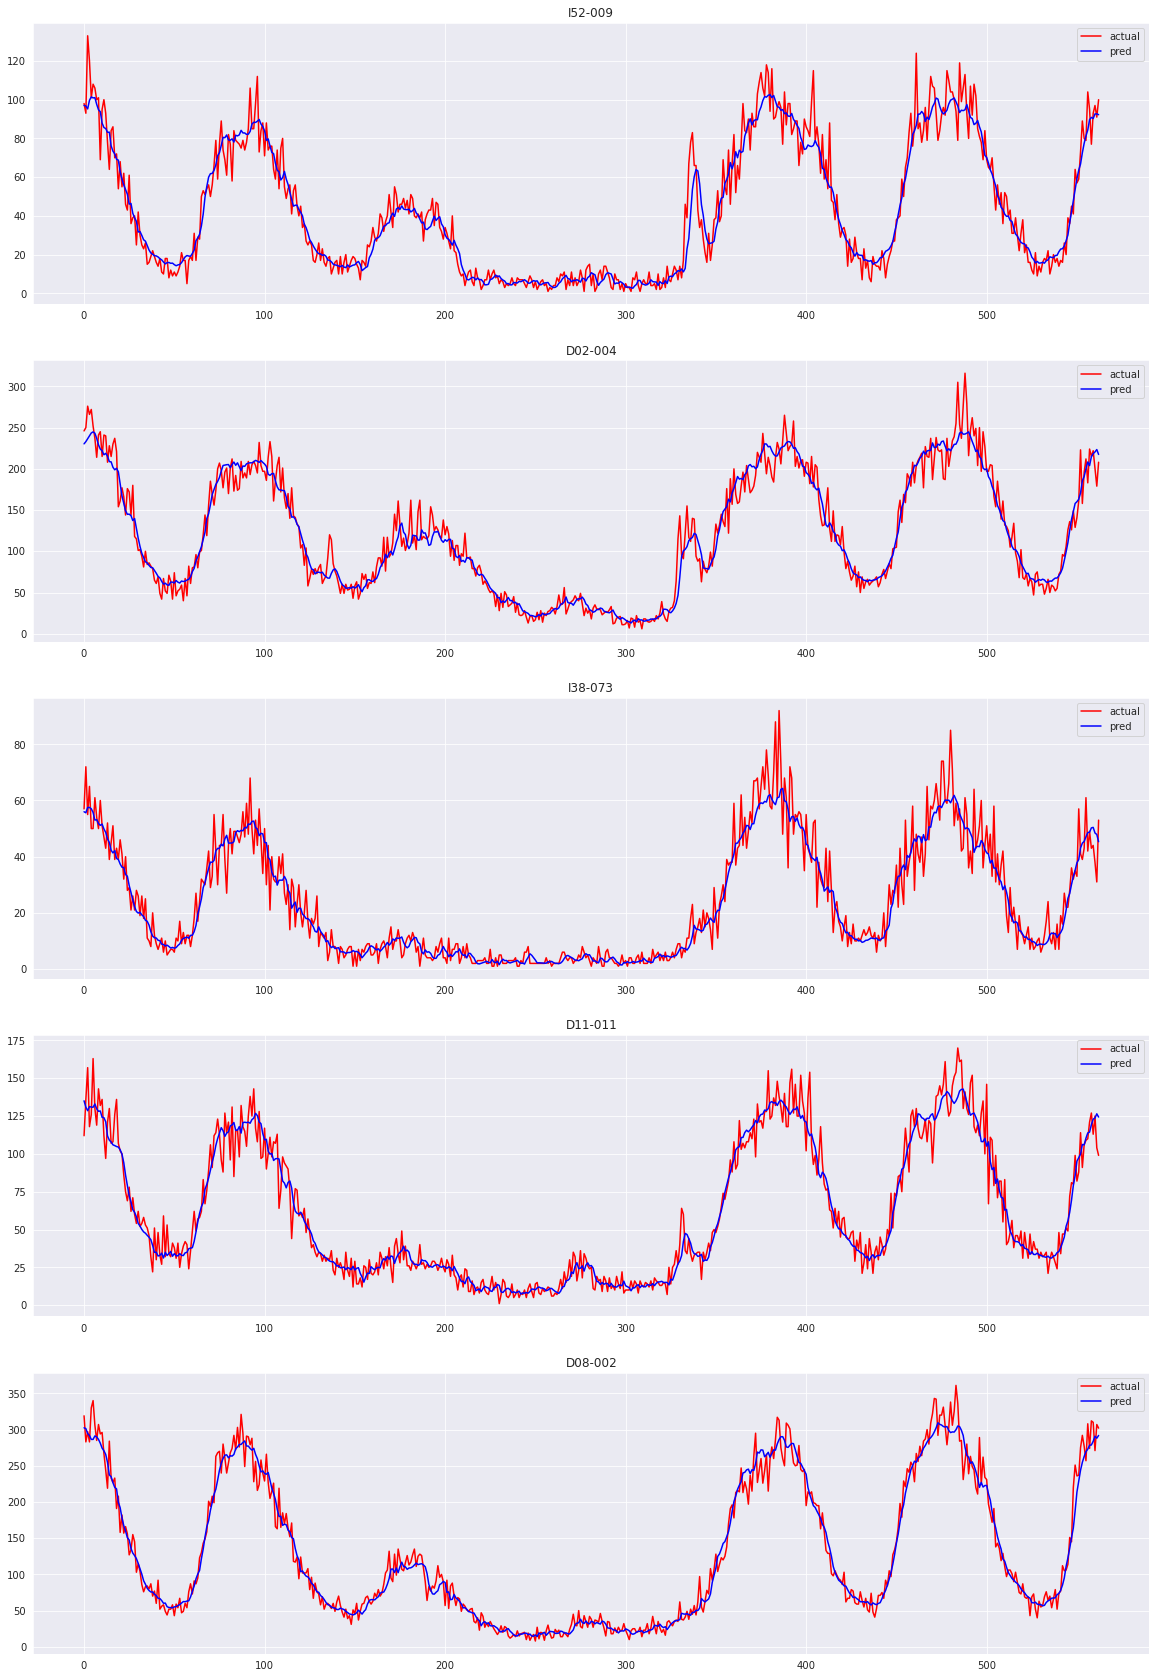

In [63]:
class VNNWithDtModel(nn.Module):
    def __init__(self, seq_len, in_channels=1, dt_dim=5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.window = seq_len
        self.in_channels = in_channels
        self.dt_dim = dt_dim
        self.hidden_dim = 32
        self.lin = nn.Linear(self.window * (self.in_channels + dt_dim), self.hidden_dim)
        self.fc = nn.Linear(self.hidden_dim, 1)

        self.dt_transformer = nn.Sequential(
            nn.Linear(self.dt_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, self.dt_dim)
        )
    
    def forward(self, X, X_dt, *args, **kwargs):
        X = X.transpose(1, 2)
        batch_size = X.shape[0]
        nodes_num = X.shape[1]

        X_dt = self.dt_transformer(X_dt)
        
        X_dt = X_dt[:, :-1]
        X_dt = X_dt.unsqueeze(-1).expand(-1, -1, -1, nodes_num).permute(0, 3, 1, 2)

        X = torch.cat((X, X_dt), dim=-1)
        X = X.reshape(batch_size, nodes_num, -1)
        out = self.lin(X)
        out = nn.functional.relu(out)
        out = self.fc(out)
        return out

model = VNNWithDtModel(seq_len=4, in_channels=1).to(device)
model = run(model, results, num_epochs=30, plot=True, plot_update_freq=5)
evaluate_plot(model, test_loader, scaler)

**VNN**

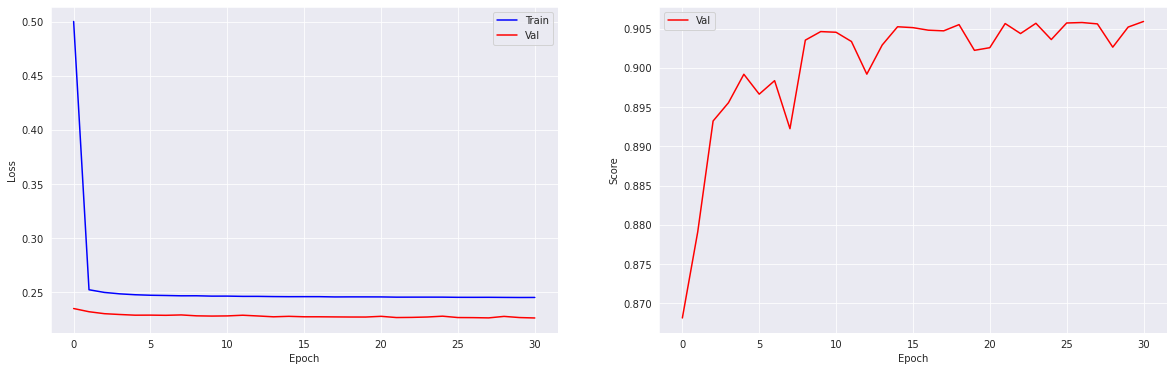

Type: VNNModel, Test loss: 0.23, Test score: 0.9015


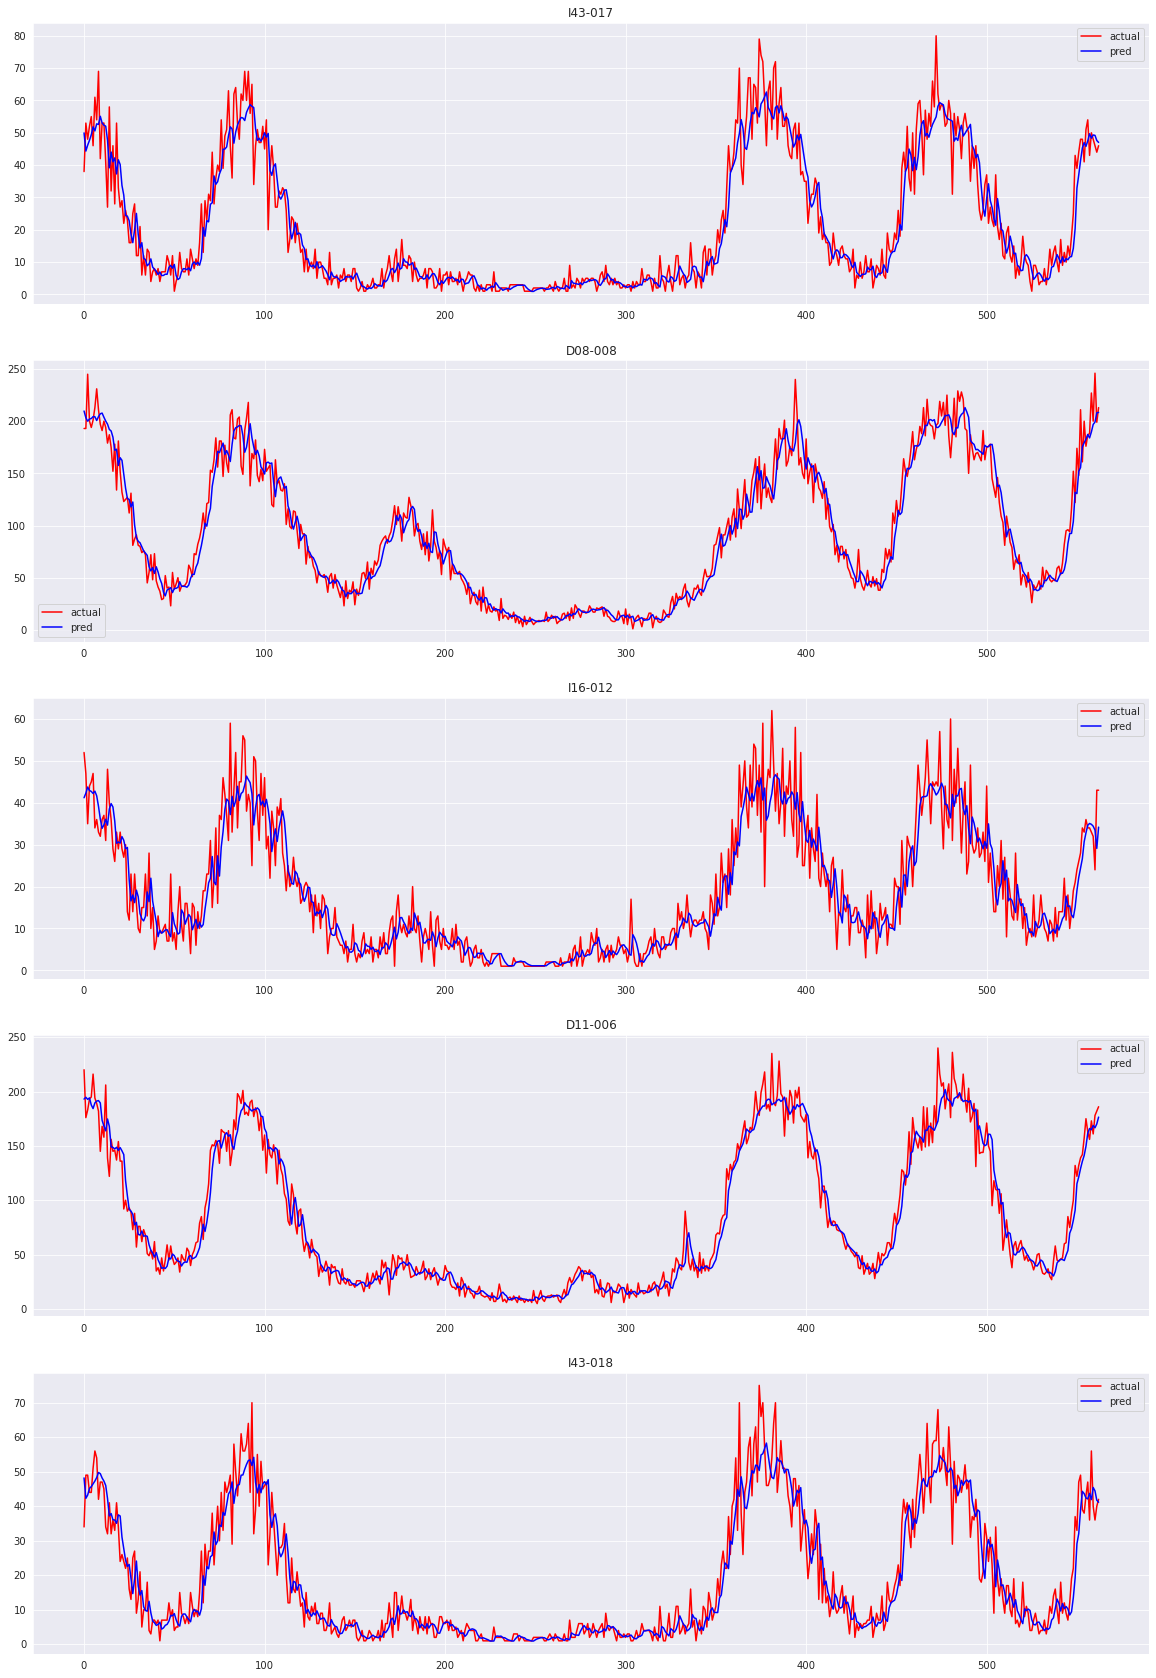

In [64]:
class VNNModel(nn.Module):
    def __init__(self, seq_len=14, in_channels=1, dt_dim=5, emb_dim=32, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.window = seq_len
        self.in_channels = in_channels
        self.dt_dim = dt_dim
        self.emb_dim = emb_dim
        self.hidden_layer = 32
        
        self.nn = nn.Sequential(
            nn.Linear(in_channels * self.window, self.hidden_layer),
            nn.ReLU(),
            nn.Linear(self.hidden_layer, 1))
    
    def forward(self, X, X_dt, emb, *args, **kwargs):
        X = X.transpose(1, 2)
        batch_size = X.shape[0]
        nodes_num = X.shape[1]
        
        X = X.reshape(batch_size, nodes_num, -1)
        out = self.nn(X)
        return out

model = VNNModel(seq_len=4, in_channels=1).to(device)
model = run(model, results, num_epochs=30, plot=True, plot_update_freq=5)
evaluate_plot(model, test_loader, scaler)

**VNN + Time Features + Node Embeddings**

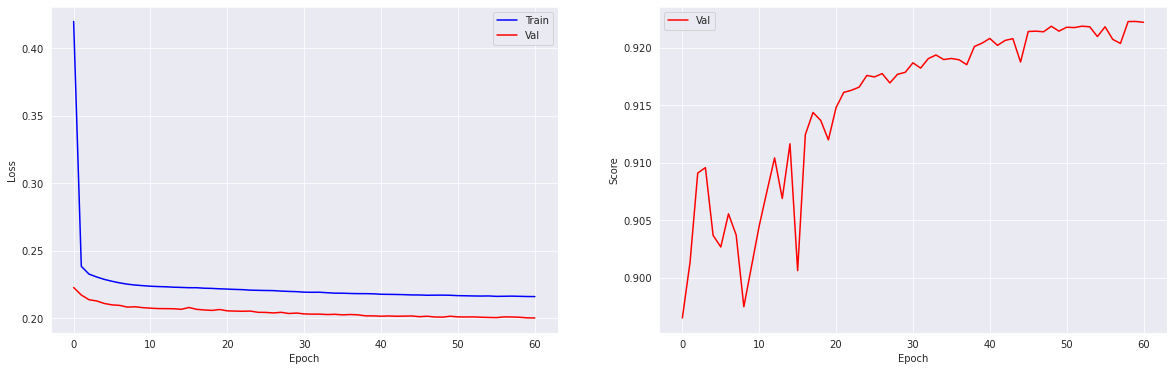

Type: VNN_WithDtEmbModel, Test loss: 0.20, Test score: 0.9179


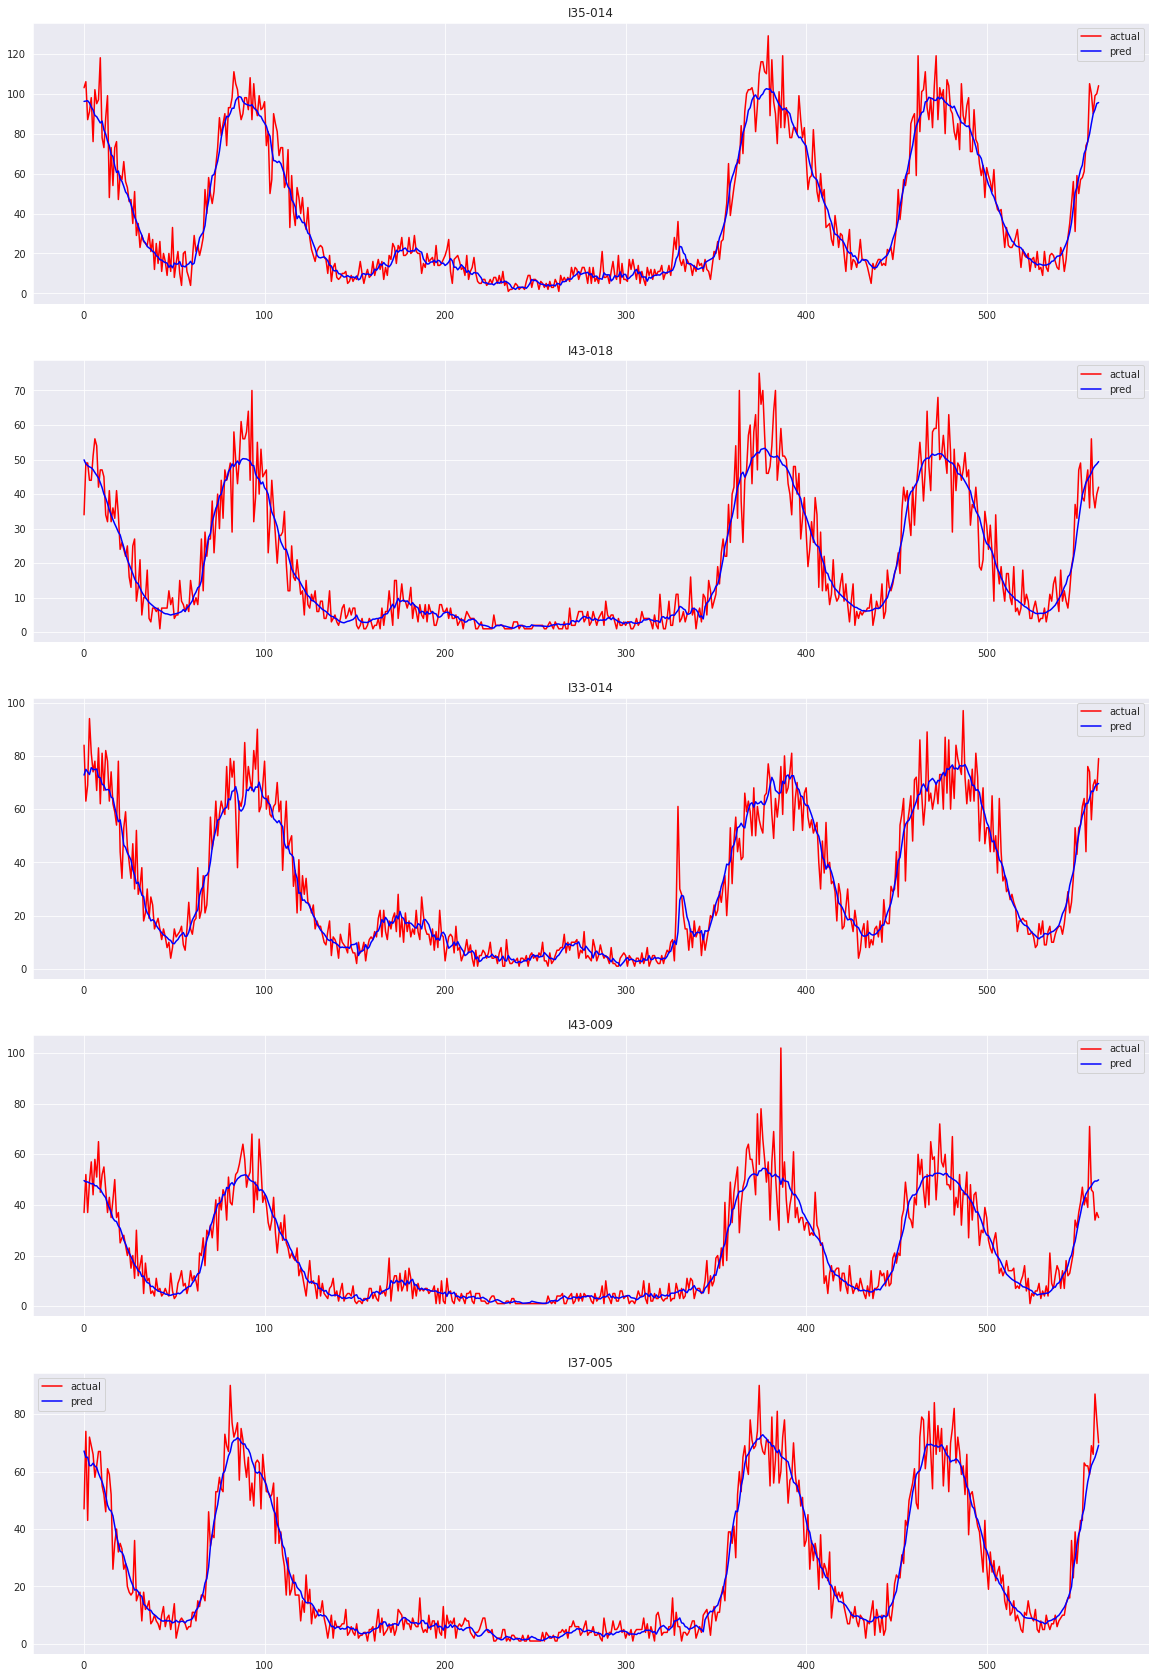

In [65]:
class VNN_WithDtEmbModel(nn.Module):
    def __init__(self, seq_len=14, in_channels=1, dt_dim=5, emb_dim=32, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.window = seq_len
        self.in_channels = in_channels
        self.dt_dim = dt_dim
        self.emb_dim = emb_dim
        self.hidden_layer = 64

        self.emb_transformer = nn.Sequential(
            nn.Linear(self.emb_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, self.emb_dim)

        )
        
        self.dt_transformer = nn.Sequential(
            nn.Linear(self.dt_dim, 64),
            nn.ReLU(),
            nn.Linear(64, self.dt_dim)
        )
        
        self.lin = nn.Linear(self.dt_dim + emb_dim + in_channels * self.window, self.hidden_layer)
        self.fc = nn.Linear(self.hidden_layer, 1)
    
    def forward(self, X, X_dt, emb, *args, **kwargs):
        X = X.transpose(1, 2)
        batch_size = X.shape[0]
        nodes_num = X.shape[1]
        
        emb = self.emb_transformer(emb)
        X_dt = self.dt_transformer(X_dt)

        X_dt = X_dt[:, -1]
        X_dt = X_dt.unsqueeze(-1).expand(-1, -1, nodes_num).permute(0, 2, 1)

        # print(X_dt.shape, X.shape)
        out = torch.cat((X_dt, emb, X.squeeze(-1)), dim=-1)
        out = self.lin(out)
        out = nn.functional.relu(out)
        out = self.fc(out)

        return out

model = VNN_WithDtEmbModel(seq_len=4, in_channels=1).to(device)
model = run(model, results, lr=5e-4, num_epochs=60, plot=True, plot_update_freq=5)
evaluate_plot(model, test_loader, scaler)

In [66]:
import json
with open('results_att.json', mode='w') as f:
    json.dump(results, f, indent=4)

**Attention**

In [67]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, dim: int, dropout: float = 0.1, max_len: int = 128):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2) * (-math.log(10000.0) / dim))
        pe = torch.zeros(max_len, dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, seq_len: int) -> Tensor:
        """
        Args:
            seq_len: int
        Returns:
            x: Tensor, shape [seq_len, dim]
        """
        x = self.dropout(self.pe[:seq_len])
        return x

In [68]:
pyg_data.edge_index

tensor([[  0,   0,   1,  ..., 647, 647, 647],
        [  1, 174,   0,  ..., 208, 209, 226]], device='cuda:0')

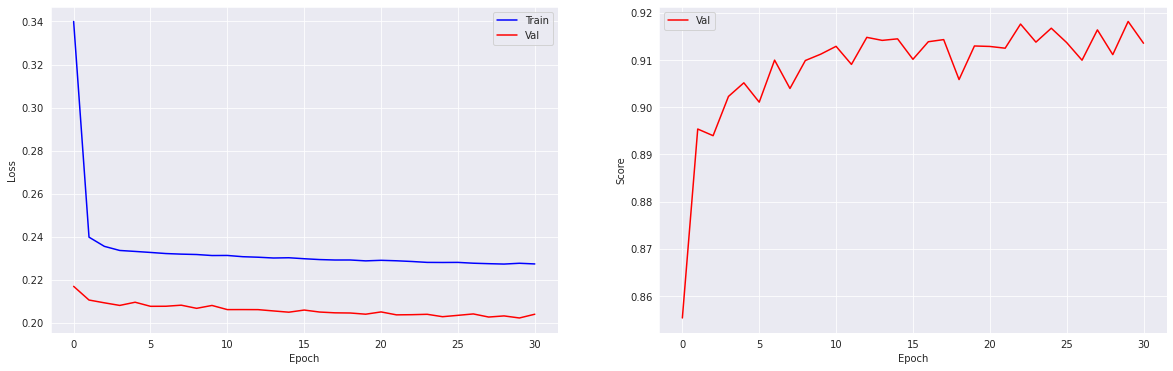

Type: STATT, Test loss: 0.20, Test score: 0.9139


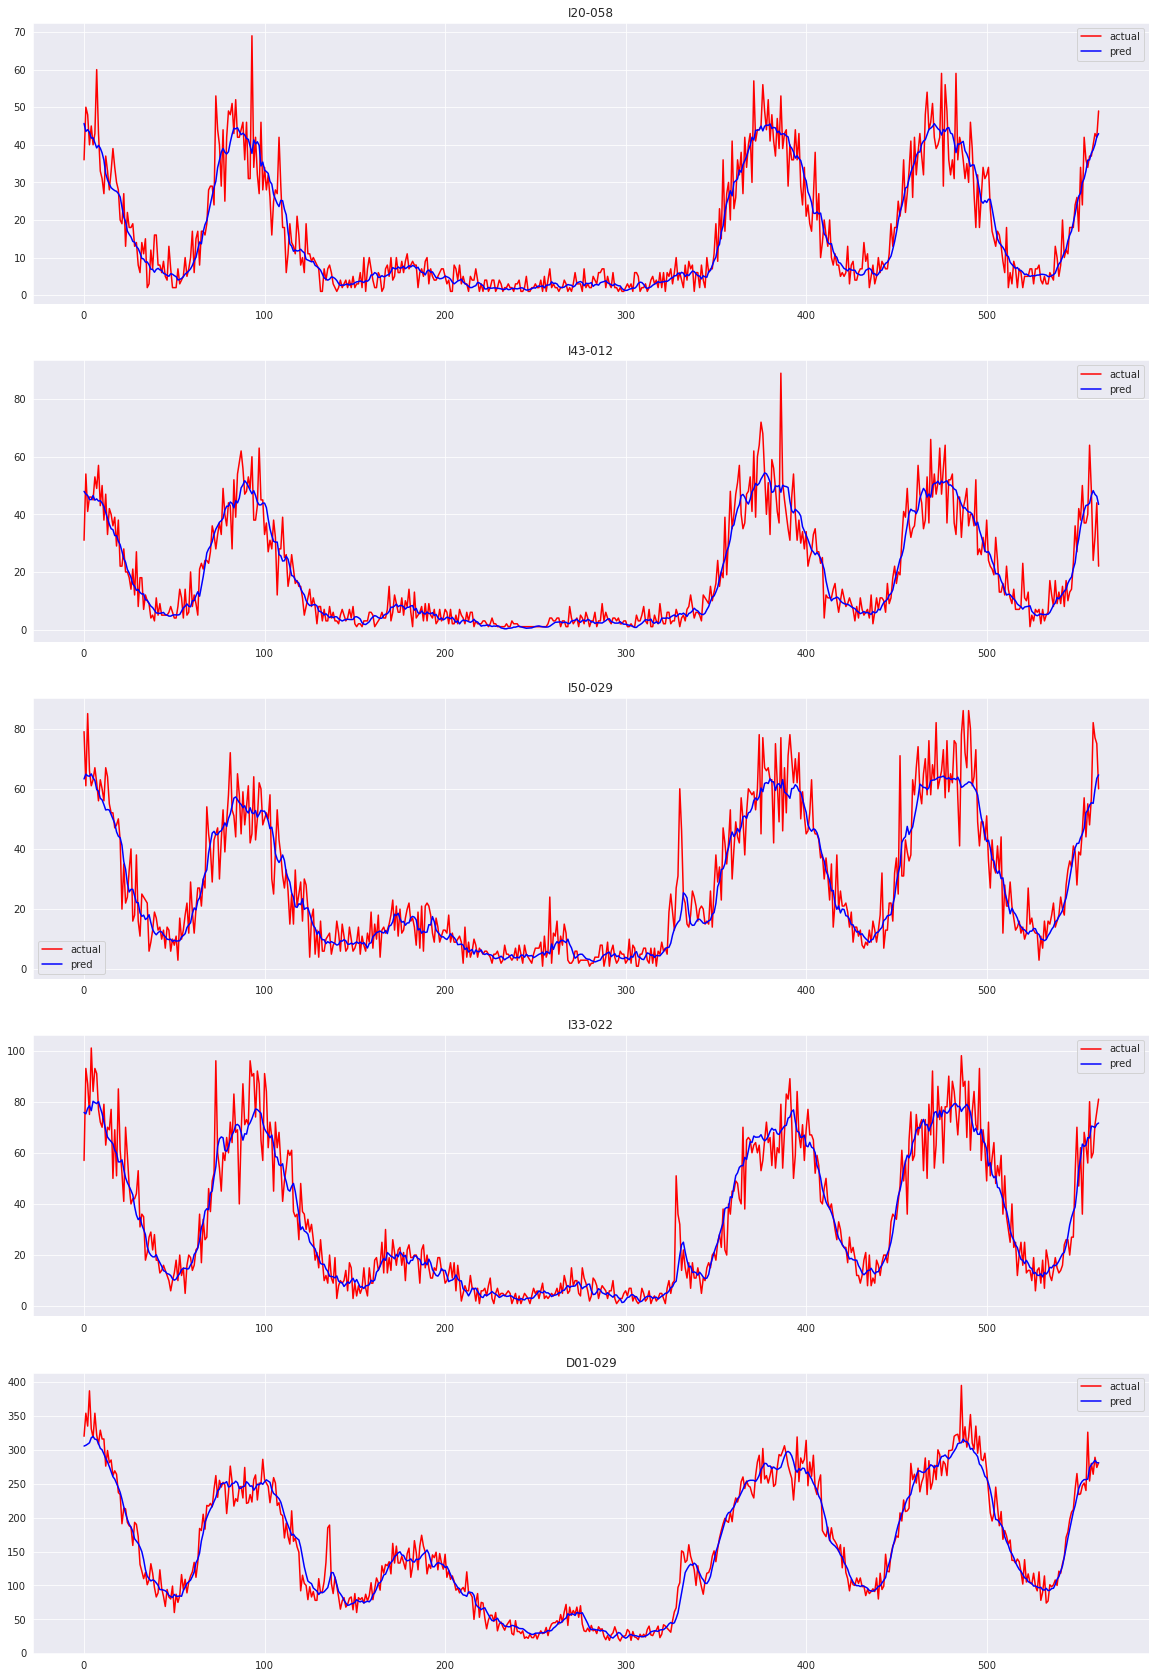

CPU times: user 11min 50s, sys: 597 ms, total: 11min 51s
Wall time: 11min 52s


In [69]:
%%time

class SpatioTemporalModule(pyg.nn.MessagePassing):
    def __init__(self, hidden_dim=64, past_emb_dim=38, future_emb_dim=37, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.hidden_dim = hidden_dim
        self.past_emb_dim = past_emb_dim
        self.future_emb_dim = future_emb_dim

        self.Q = nn.Linear(future_emb_dim, self.hidden_dim)
        self.K = nn.Linear(past_emb_dim, self.hidden_dim)
        self.V = nn.Linear(past_emb_dim, self.hidden_dim)
        # self.M = nn.Linear(future_emb_dim, self.hidden_dim)

        self.ffn = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim * 2),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim * 2, 1))

    def forward(self, past_emb, future_emb, edge_index):
        """Returns estimated targets for query nodes using scaling features and node embeddings.
        This function works utilizing message passing principle. For more information check the following link
        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html

        Args:
            past_emb (torch.Tensor), shape [nodes_num, seq_len, past_emb_dim]: embeddings for the past observations
            future_emb (torch.Tensor), shape [nodes_num, future_emb_dim]: embeddings for the time T + 1
            edge_index (torch.Tensor): edges for the bipartite graph

        Returns:
            torch.Tensor, shape[nodes, 1]: estimated targets for nodes on T+1
        """

        # print(edge_index[:, :20])
        past_emb = past_emb.reshape(-1, past_emb.size(-1))

        q = self.Q(future_emb)
        k = self.K(past_emb)
        v = self.V(past_emb)

        out = self.propagate(edge_index, 
            v=v, k=k, q=q, 
            size=(past_emb.size(0), future_emb.size(0)))
        
        # out = torch.cat([out, self.M(future_emb)], dim=-1)
        
        out = self.ffn(out)

        return out

    def message(self, v_j, k_j, q_i, index):
        # print(x_j.shape, x_i.shape, index.shape)
        # k = self.K(x_j)
        # # v = self.V(x_j)
        # v = x_j[:, 0].unsqueeze(-1)
        # q = self.Q(x_i)

        logits = torch.sum(k_j * q_i, dim=1) / math.sqrt(self.hidden_dim)
        att_weights = pyg.utils.softmax(logits, index)
        # print(att_weights.shape, v.shape)
        # out = att_weights[:, None].expand(-1, self.hidden_dim) 
        out = att_weights[:, None] * v_j
        return out


class STATT(nn.Module):
    def __init__(self, seq_len=14, in_dim=1, dt_dim=5, emb_dim=32, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.window = seq_len
        self.in_dim = in_dim
        self.dt_dim = dt_dim
        self.emb_dim = emb_dim
        self.pos_enc_dim = 8
        self.hidden_layer = 16

        self.emb_transformer = nn.Sequential(
            nn.Linear(self.emb_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, self.emb_dim)

        )
        self.dt_transformer = nn.Sequential(
            nn.Linear(self.dt_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, self.dt_dim)
        )

        self.PE = PositionalEncoding(dim=self.pos_enc_dim)
        self.ST_Module = SpatioTemporalModule()
    
    def _make_spatio_temporal_edge_index(self, edge_index, seq_len, device=device):
        # print(edge_index.shape)
        E, _ = pyg.utils.add_self_loops(edge_index)
        # print(E.shape)
        # E = edge_index
        # E = torch.vstack([torch.arange(0, 12), torch.arange(0, 12)]).to(device)
 
        out = torch.vstack([
            torch.cat([torch.arange(s * seq_len, (s + 1) * seq_len) for s in E[0]]).to(device),
            E[1][:, None].expand(-1, seq_len).reshape(-1)])

        return out

    def _make_temporal_edge_index(self, nodes_num, seq_len, device=device):
        return torch.vstack([
            torch.arange(0, nodes_num * seq_len, 1),
            torch.arange(0, nodes_num, 1)[:, None].expand(-1, seq_len).reshape(-1)]).to(device)

    def positional_encode(self, X):
        """Adds positional encoding to embeddings

        Args:
            X (Tensor), shape [batch_size, nodes_num, seq_len, emb_dim]
        Returns:
            out (Tensor), shape [batch_size, nodes_num, seq_len, emb_dim + pe_dim]
        """
        batch_size, nodes_num, seq_len, emb_dim = X.shape
        pe = torch.fliplr(self.PE(seq_len))[None, :].expand(batch_size * nodes_num, -1, -1)
        X = X.reshape(-1, seq_len, emb_dim)
        out = torch.cat([X, pe], dim=-1).reshape(batch_size, nodes_num, seq_len, emb_dim + self.pos_enc_dim)
        return out

    def compose_future_emb(self, X_dt, node_embs):
        X_tp1 = X_dt[:, :, -1]
        X_future = torch.cat((X_tp1, node_embs), dim=-1)
        return X_future
    
    def compose_past_emb(self, X, X_dt, node_embs):
        past_dt = X_dt[:, :, :-1]
        X_past = torch.cat(
            (X,
             past_dt,
             node_embs.unsqueeze(-1).expand(-1, -1, -1, self.window).permute(0, 1, 3, 2)),
        dim=-1)
        # out = self.positional_encode(X_past)
        out = X_past
        # print(out.shape)
        return out

    def forward(self, X, X_dt, emb, edge_index, *args, **kwargs):
        X = X.transpose(1, 2)
        batch_size = X.shape[0]
        nodes_num = X.shape[1]

        # print(X.shape, X_dt.shape, emb.shape)
        
        # learning new embeddings
        emb = self.emb_transformer(emb)
        X_dt = self.dt_transformer(X_dt)

        X_dt = X_dt.unsqueeze(-1).expand(-1, -1, -1, nodes_num).permute(0, 3, 1, 2)
        
        past_emb = self.compose_past_emb(X, X_dt, emb)
        future_emb = self.compose_future_emb(X_dt, emb)

        # print(past_emb.shape, future_emb.shape)

        # edge_index = self._make_temporal_edge_index(past_emb.shape[1], past_emb.shape[2])
        edge_index = self._make_spatio_temporal_edge_index(edge_index[0], past_emb.shape[2])

        torch_streams = [torch.cuda.Stream() for _ in range(batch_size)]
        torch.cuda.synchronize()
        batch_res = []
        for i, s in enumerate(torch_streams):
            with torch.cuda.stream(s):
                batch_res.append(self.ST_Module(past_emb[i], future_emb[i], edge_index))
        torch.cuda.synchronize()

        out = torch.hstack(batch_res).T
        out = out.unsqueeze(-1)
        return out

model = STATT(seq_len=4, in_dim=1).to(device)
model = run(model, results, lr=1e-3, num_epochs=30, plot=True, plot_update_freq=1)
evaluate_plot(model, test_loader, scaler)